## <u>*Regression Modelling for claims cost as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

In [3]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


In [4]:
df.groupby("gender")["claimcst0"].mean().to_frame()

,claimcst0
gender,
F,127.159782
M,150.612087


In [5]:
df.groupby("agecat")["claimcst0"].mean().to_frame()

,claimcst0
agecat,
1,227.685980
2,154.162388
3,135.225920
4,132.516093
5,98.864771
6,104.409426


In [6]:
df.groupby("veh_age")["claimcst0"].mean().to_frame()

,claimcst0
veh_age,
1,126.887077
2,149.889496
3,135.478319
4,134.837211


In [7]:
df.groupby("veh_body")["claimcst0"].mean().to_frame()

,claimcst0
veh_body,
BUS,278.398333
CONVT,85.047037
COUPE,240.670834
HBACK,136.882696
HDTOP,186.707960
MCARA,84.046850
MIBUS,161.931492
PANVN,177.012517
RDSTR,50.720673


In [8]:
df.groupby("area")["claimcst0"].mean().to_frame()

,claimcst0
area,
A,127.008681
B,134.569760
C,139.518365
D,111.471694
E,146.959224
F,224.135098


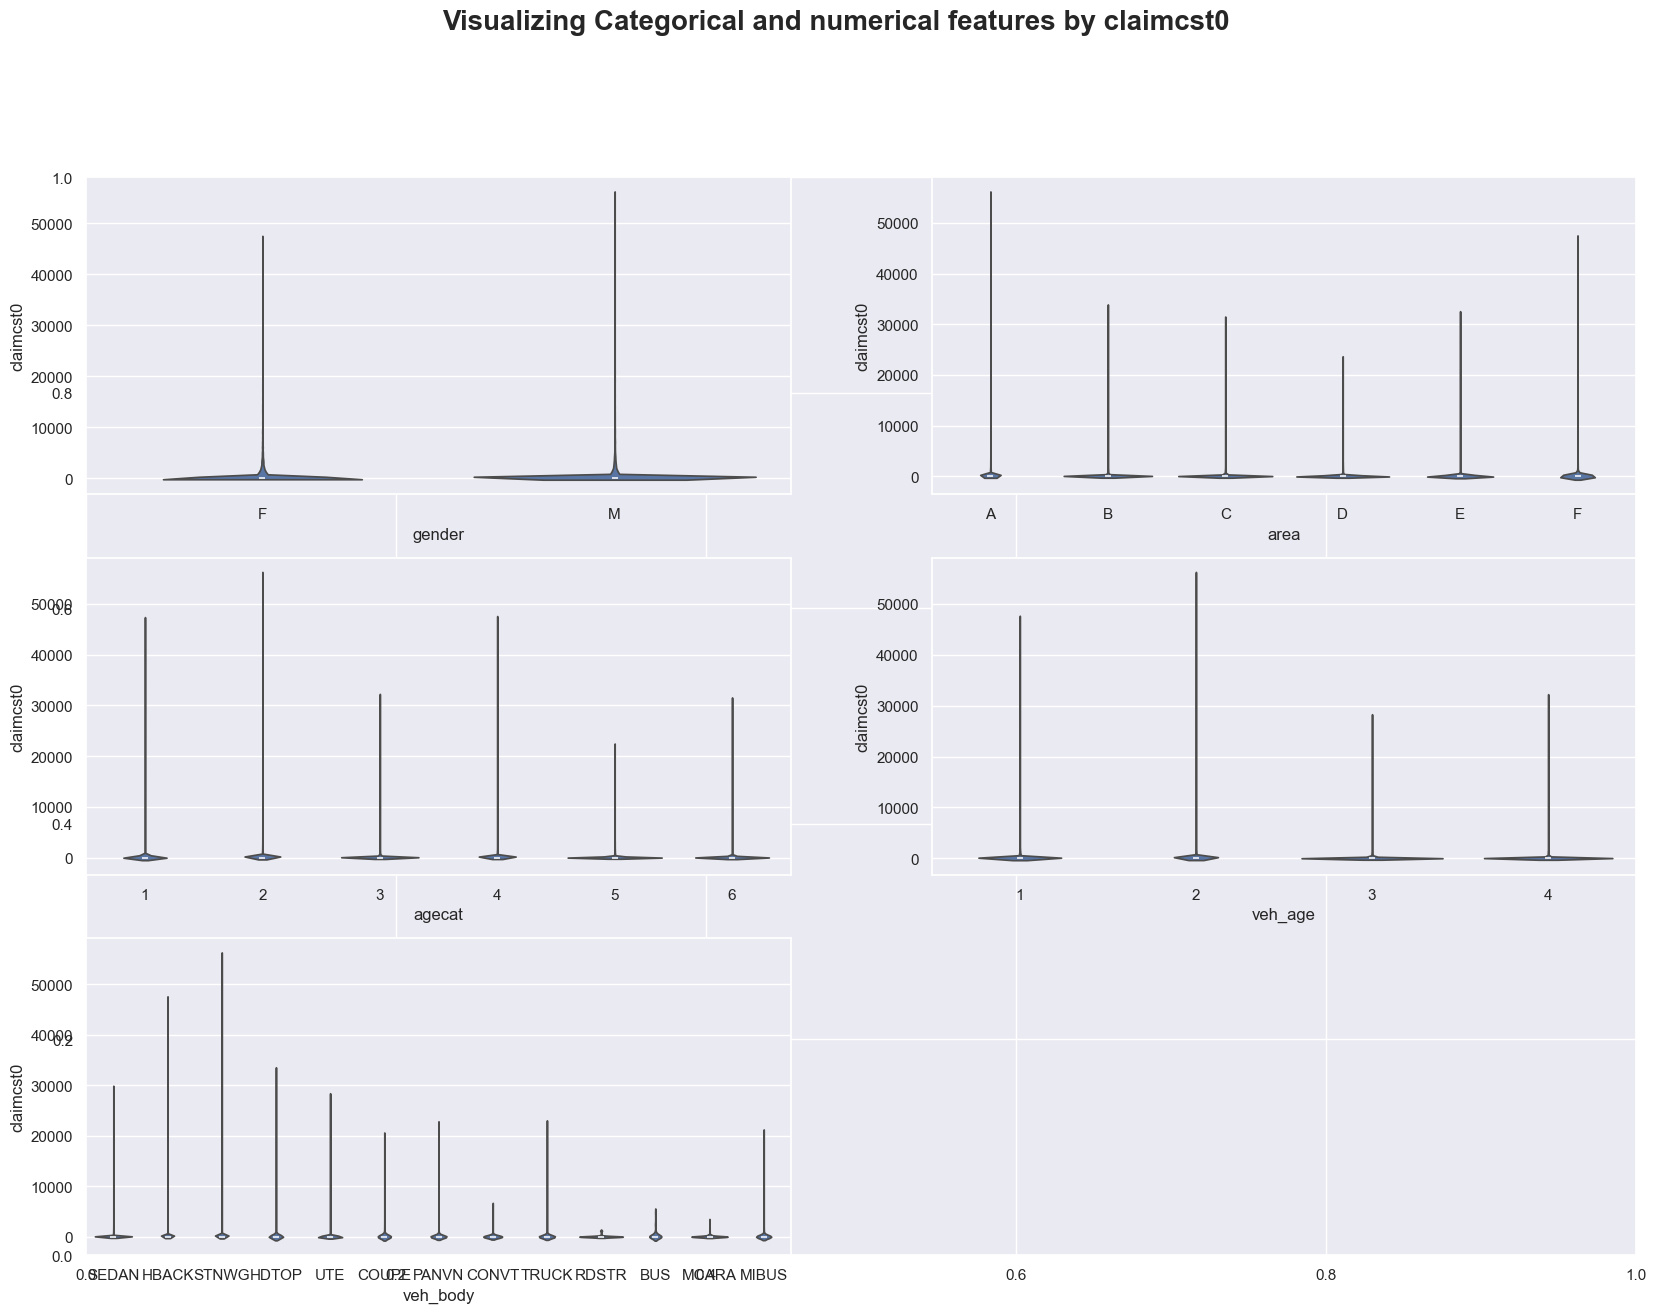

In [11]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by claimcst0",fontsize=20,fontweight="bold",y=1.)
plt.subplot(321)
sns.violinplot(x="gender",y="claimcst0",data=df)
plt.subplot(322)
sns.violinplot(x="area",y="claimcst0",data=df)
plt.subplot(323)
sns.violinplot(x="agecat",y="claimcst0",data=df)
plt.subplot(324)
sns.violinplot(x="veh_age",y="claimcst0",data=df)
plt.subplot(325)
sns.violinplot(x="veh_body",y="claimcst0",data=df)

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_claimcst0.png',dpi=500);


In [12]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [13]:
x=df.drop("claimcst0",axis=1)
y=df["claimcst0"]

In [15]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [17]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value']
df[transform_features]=pt.fit_transform(x[transform_features])

In [18]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [19]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    #("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,x.columns)
]
)

In [20]:
x=preprocessor.fit_transform(x)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (54284, 7) and Y = (54284,) : 
Test data shape of X = (13572, 7) and Y = (13572,) : 


---

*Define models :*

In [22]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor()
}

*Create cross validation evaluation_fucntion*

In [23]:
def evaluation_preds_list(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    metrics_dict={
       "RMSE": round(RMSE,3)
    }
   
    return metrics_dict

In [24]:
def evaluation_preds(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    return RMSE

In [25]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    RMSE_list=[]

    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_RMSE=evaluation_preds(y_test,test_predicted)
       
        RMSE_list.append(test_predicted_RMSE)

        print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        print( test_predicted_RMSE)
        print("===========================")

    report=pd.DataFrame(list(zip(models_list,RMSE_list)),columns=["model","RMSE"]).sort_values(by="RMSE",ascending=True) 
    return report
  

In [26]:
evalua_models(x_train,y_train,models)

RandomForestRegressor
1069.1082251751734
DecisionTreeRegressor
1518.813237688332
XGBRFRegressor
1010.6141486051813
GradientBoostingRegressor
1045.1735359369197
AdaBoostRegressor
1837.9683415024542


,model,RMSE
2,XGBRFRegressor,1010.614149
3,GradientBoostingRegressor,1045.173536
0,RandomForestRegressor,1069.108225
1,DecisionTreeRegressor,1518.813238
4,AdaBoostRegressor,1837.968342


In [27]:
np.random.seed(42)
clf=XGBRFRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

In [29]:
clf.feature_names=list(df.drop("claimcst0",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.132234
1,exposure,0.136225
2,veh_body,0.082082
3,veh_age,0.186216
4,gender,0.221200
5,area,0.158796
6,agecat,0.083246


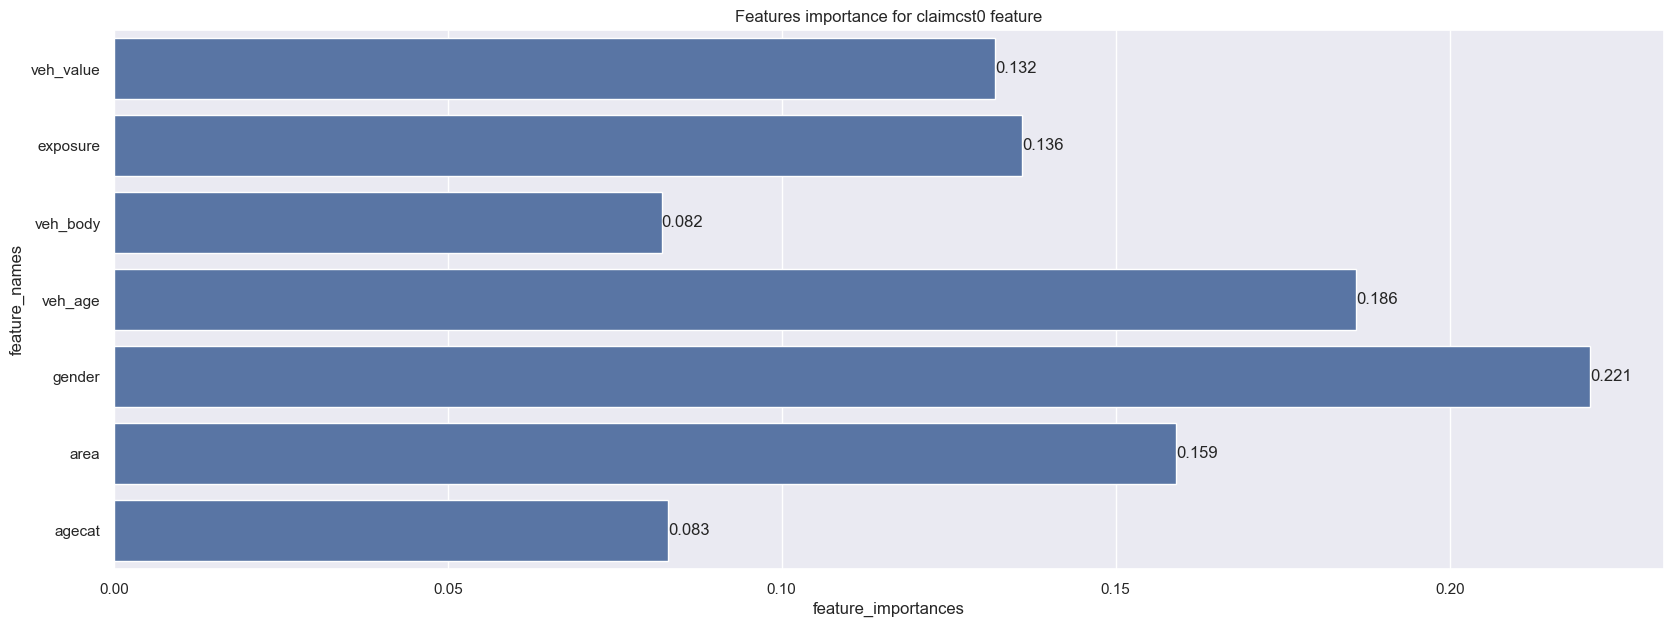

In [31]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for claimcst0 feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/claimcst0_featureImportanc.png',dpi=500);

In [32]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/claimcst0_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---